# Decode cypher text

### Welcome!
This notebook can decode cypher text. It uses a DFA created by the method outlined here
[Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook will automatically train an RNN on symplfied set of english, and extract a DFA from that RNN.


# Code below

In [10]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Extraction import extract

import time
import random

from memory_profiler import profile

import FalseWordGenerator as FWG

import ALPHABET_26
ALPHABET = ALPHABET_26.ALPHABET
print (ALPHABET)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [11]:
#import pickle
#with open('falseWords.pkl', 'rb') as f:
#    MEANINGLESS_WORDS = (pickle.load, f)

MEANINGFUL_WORDS = ALPHABET_26.WORDS[:10000]
MEANINGLESS_WORDS = FWG.generateFalseWords(ALPHABET, MEANINGFUL_WORDS)
#MEANINGLESS_WORDS = MEANINGLESS_WORDS[:10000]
def target(w):             
   if w.lower() in MEANINGFUL_WORDS:
      return True
   else:
      return False
    
train_set = {}
train_set.update({w: True for w in MEANINGFUL_WORDS})
train_set.update({w: False for w in MEANINGLESS_WORDS})
print ("made training set of size: " + str(len(train_set)))
print ("of which " + str(len(MEANINGFUL_WORDS)) + str(" are positive"))
print ("of which " + str(len(MEANINGLESS_WORDS)) + str(" are negative"))

made training set of size: 15696
of which 10000 are positive
of which 9988 are negative


In [12]:
print (train_set)

#import pickle

#with open('falseWords.pkl', 'wb') as f:
#    pickle.dump(MEANINGLESS_WORDS, f)

{'breathe': True, 'respire': True, 'choke': True, 'hyperventilate': True, 'aspirate': True, 'burp': True, 'hiccup': True, 'sigh': True, 'exhale': True, 'hold': True, 'sneeze': True, 'inhale': True, 'pant': True, 'cough': True, 'hack': True, 'expectorate': True, 'snort': True, 'wheeze': True, 'puff': True, 'blow': True, 'insufflate': True, 'yawn': True, 'sniff': True, 'blink': True, 'palpebrate': True, 'bat': True, 'wink': True, 'squint': True, 'wince': True, 'shed': True, 'desquamate': True, 'twitch': True, 'fibrillate': True, 'act': True, 'presume': True, 'vulgarize': True, 'optimize': True, 'quack': True, 'menace': True, 'make': True, 'swagger': True, 'freeze': True, 'wanton': True, 'romanticize': True, 'sentimentalise': True, 'bungle': True, 'play': True, 'stooge': True, 'shake': True, 'shiver': True, 'rest': True, 'sleep': True, 'bundle': True, 'snooze': True, 'nap': True, 'oversleep': True, 'hibernate': True, 'estivate': True, 'drowse': True, 'nod': True, 'snore': True, 'doss': Tr

# Train and Extract with the optimal network

In [13]:
rnnOpt = RNNClassifier(ALPHABET,num_layers=3,hidden_dim=50,RNNClass = LSTMNetwork)

current average loss is:  0.06569387428453613


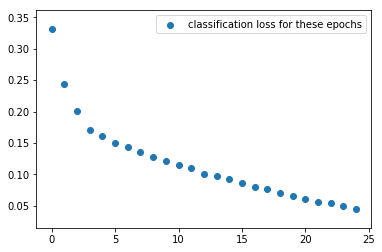

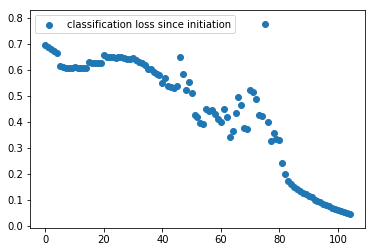

classification loss on last batch was: 0.04468886519590661


In [14]:
mixed_curriculum_train(rnnOpt,train_set,stop_threshold = 0.05)

In [15]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnOpt.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnOpt.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]

In [16]:
rnnOpt.renew()

In [17]:
dfaOpt = extract(rnnOpt,time_limit = 120, initial_split_depth = 10, starting_examples = starting_examples)

provided counterexamples are: ['up', 'cl']
obs table refinement took 0.003
guided starting equivalence query for DFA of size 2
storing provided counterexample of length 2
returning counterexample of length 2:		cl, this counterexample is rejected by the given RNN.
equivalence checking took: 0.00044863900006930635
obs table refinement took 0.306
guided starting equivalence query for DFA of size 8
['', 'a']
['', 'a', 'b']
refining, H size is 2
split wasn't perfect: gotta start over
['b', 'c']
['b', 'c', 'd']
refining, H size is 2
['b', 'c', 'g']
refining, H size is 2
['a', 'i']
['d', 'k']
['g', 'm']
refining, H size is 1
['g', 'p']
['n', 't']
['a', 'i', 'u']
['q', 'v']
['g', 'p', 'w']
['g', 'p', 'w', 'x']
refining, H size is 3
['d', 'k', 'y']
['x', 'z']
returning counterexample of length 2:		zh, this counterexample is rejected by the given RNN.
equivalence checking took: 0.6602572110000438
obs table refinement took 0.785
guided starting equivalence query for DFA of size 16
['b', 'c']
['a'

# Cypher some messages

In [18]:
from MessageMaker import makeMessage

messageLength = 5

messages = []
for i in range (500):
    messages.append(makeMessage(MEANINGFUL_WORDS, messageLength))

In [19]:
import cypher_creation as c

rotationCypheredMessages = []
for message in messages:
    rotationCypheredMessages.append(c.rotate_sentence(message, ALPHABET))
    
swappedCypherMessages = []
for message in messages:
    swappedCypherMessages.append(c.swap_letters(message, ALPHABET)[0])

# Attempt to crack the rotation cyphers

In [22]:
import Rotation_Checker as RCT

preCountRNN = 0.0
accCountRNN = 0.0  
hitRateRNN = 0.0
startTime = time.time()
for index in range(len(rotationCypheredMessages)):
    rnnReport = RCT.checkRtCy(rotationCypheredMessages[index], ALPHABET, rnnOpt)
    message = messages[index]
    preCountRNN += float(rnnReport[0])
    if message in rnnReport[1]:
        accCountRNN += 1 / len(rnnReport[1])
        hitRateRNN += 1

accuracyRNN = accCountRNN / len(rotationCypheredMessages)
precisionRNN = preCountRNN / len(rotationCypheredMessages)
hitRateRNN = hitRateRNN / len(rotationCypheredMessages)
rnnRunTime = time.time() - startTime
print ('accuracy of RNN: ', accuracyRNN)#how many answer were correct out of the the returned answers
print ('precision of RNN: ',precisionRNN)#how likely this is to be the decrypted message
print ('hitRate of DFA: ', hitRateRNN)#how often the correct answer was returned
print ('runtime of RNN: ',rnnRunTime)
print("\n")


preCountDFA = 0.0
accCountDFA = 0.0 
hitRateDFA = 0.0
startTime = time.time()
for index in range(len(rotationCypheredMessages)):
    rnnReport = RCT.checkRtCy(rotationCypheredMessages[index], ALPHABET, dfaOpt)
    message = messages[index]
    preCountDFA += float(rnnReport[0])
    if message in rnnReport[1]:
        accCountDFA += 1 / len(rnnReport[1])
        hitRateDFA += 1
accuracyDFA = accCountDFA / len(rotationCypheredMessages)#how many answer were correct out of the the returned answers
precisionDFA = preCountDFA / len(rotationCypheredMessages)#how likely this is to be the decrypted message
hitRateDFA = hitRateDFA / len(rotationCypheredMessages)#how often the correct answer was returned
dfaRunTime = time.time() - startTime
print ('accuracy of DFA: ', accuracyDFA)
print ('precision of DFA: ',precisionDFA)
print ('hitRate of DFA: ', hitRateDFA)
print ('runtime of DFA: ',dfaRunTime)

print("\n")
'''
import BruteForce as BF
accCountBF = 0.0 
hitRateBF = 0.0
startTime = time.time()
for index in range(len(rotationCypheredMessages)):
    bfReport = BF.checkInList(rotationCypheredMessages[index])
    message = messages[index].split()
    if message in bfReport:
        accCountBF += 1/ len(bfReport)
        hitRateBF += 1
bfRunTime = time.time() - startTime
accuracyBF = accCountBF / len(rotationCypheredMessages)
hitRateBF = hitRateBF / len(rotationCypheredMessages)
print ('accuracy of BF: ', accuracyBF)
print ('hitRate of BF: ', hitRateBF)
print ('runtime of BF: ',bfRunTime)

import sys
print (sys.getsizeof(MEANINGFUL_WORDS))
print (sys.getsizeof(dfaOpt))
print (sys.getsizeof(rnnOpt))
'''

MemoryError: bad allocation

In [23]:
import BFAlt as BF
accCountBF = 0.0 
hitRateBF = 0.0
startTime = time.time()
for index in range(len(rotationCypheredMessages)):
    bfReport = BF.checkInList(rotationCypheredMessages[index])
    message = messages[index].split()
    if message in bfReport:
        accCountBF += 1/ len(bfReport)
        hitRateBF += 1
bfRunTime = time.time() - startTime
accuracyBF = accCountBF / len(rotationCypheredMessages)
hitRateBF = hitRateBF / len(rotationCypheredMessages)
print ('accuracy of BF: ', accuracyBF)
print ('hitRate of BF: ', hitRateBF)
print ('runtime of BF: ',bfRunTime)

import sys
print (sys.getsizeof(MEANINGFUL_WORDS))
print (sys.getsizeof(dfaOpt))
print (sys.getsizeof(rnnOpt))

accuracy of BF:  1.0
hitRate of BF:  1.0
runtime of BF:  0.34467148780822754
80064
56
56


# Attempt to crack the swap cyphers

In [ ]:
import frequencyAnalysis as fa

from collections import Counter
SENTENCE="eat is ir tae ate"
output = fa.freqAnalysisSwap(MEANINGFUL_WORDS, SENTENCE)
print (output)

In [ ]:
#Call draw_nicely to hijack the dfa
dfaOpt.draw_nicely(maximum=300)

for index in range(len(swappedCypherMessages)):
    cypherMessage = swappedCypherMessages[index]
    message = messages[index]
    decypheredMessage = ""
    for word in cypherMessage.split():
        actualWord = dfaOpt.wordsWithWordnessScore(list(word))
        decypheredMessage += " " +"".join(actualWord)
    print(message)
    print(decypheredMessage)

#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

In [ ]:
#from math import pow
#def percent(num,digits=2):
#    tens = pow(10,digits)
#    return str(int(100*num*tens)/tens)+"%"
#print("hello")
#dfaOpt.draw_nicely(maximum=300) #max size willing to draw
#print("hi")

#word = list("ASOI")
#actualWord = dfaOpt.wordsWithWordnessScore(word)
#print("originialWord :", actualWord)

In [ ]:
word = list("asoi")
actualWord = dfaOpt.wordsWithWordnessScore(word)
print("originialWord :", actualWord)

In [ ]:
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfaOpt.draw_nicely(maximum=300) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")

Rotation Cypher Checker